# `Fitty`: Fitting dose-response data to Emax/Hill function model

**Author: Raibatak Das**  
Last updated: **2024-OCT-10**

This jupyter notebook is part of the documentation for the Julia package `Fitty` for nonlinear least squares regression. In this example, the optical density -vs- concentration data from an ELISA assay is fit to a logistic model. 

In [1]:
using DataFrames, LaTeXStrings, PythonPlot, Statistics
using Pkg
Pkg.activate("..")
import Fitty

  Activating project at `~/quantilogix/projects/Fitty`


In [2]:
# ONLY RELEVANT ON A MAC WITH RETINA DISPLAY

# Run macro to produce high resolution plots
# on a retina display
@pyplot_retina
# Update matplotlib settings
mpl = PythonPlot.matplotlib
mpl.rcParams["font.size"] = 14;
mpl.rcParams["figure.dpi"] = 180;
mpl.rcParams["axes.axisbelow"] = true;
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color = mpl.colormaps["Dark2"].colors);

## 1. Load and plot data

This examples uses the `DNase` dataset that reports the optical density of a sample as a function of the concentration of recombinant protein DNase in rat serum (Ref: https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/DNase.html)

In [3]:
data = Fitty.loadDataset("DNase")

Row,Run,conc,density
,Int64,Float64,Float64
1,1,0.0488281,0.017
2,1,0.0488281,0.018
3,1,0.195312,0.121
4,1,0.195312,0.124
5,1,0.390625,0.206
6,1,0.390625,0.215
7,1,0.78125,0.377
8,1,0.78125,0.374
9,1,1.5625,0.614


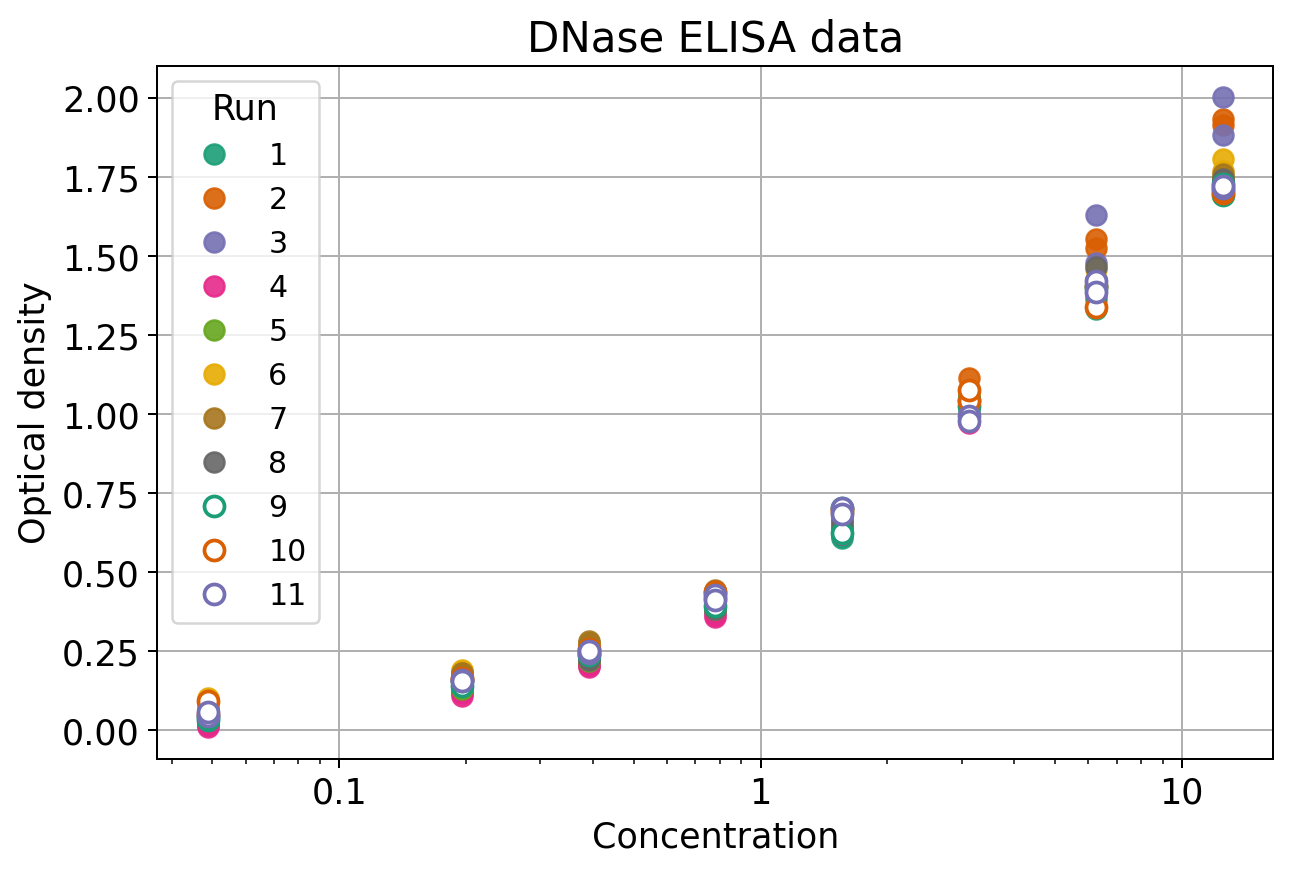

In [4]:
fig, ax = subplots(figsize = (8, 5))
for (run, df) in pairs(groupby(data, :Run, sort = false))
    r = run.Run
    if r < 9
        ax.plot(df.conc, df.density, "o", ms = 8, alpha = 0.9, label = r)
    else
        ax.plot(df.conc, df.density, "o", ms = 8, mew = 1.5, mfc = "w", label = r)
    end
end
ax.set_xlabel("Concentration")
ax.set_ylabel("Optical density")
ax.legend(title = "Run", fontsize = 12)
ax.set_title("DNase ELISA data")
ax.set_xscale("log")
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels(["0.1", "1", "10"])
ax.grid();

## 2. Define model and residual functions

These data are fit to a Hill function that describes a saturable dose-response:
$$y = y_0 + \frac{y_\text{\sf max} - y_0}{1 + (EC_{50}/x)^n}$$

where
$$\begin{aligned}
y & = \text{Density} \\
x & = \log(\text{Concentration})
\end{aligned} $$

Under this model, the baseline response, $y_0$, is the optical density in the absence of any sample (typically, with buffer or media only), and $y_\text{\sf max}$ is the asymptotic maximum response. The density is halfway between $y_0$ and $y_\text{\sf max}$ when the concentration is $EC_{50}$. The Hill coefficient $n$ controls the slope of the dose-response at $EC_{50}$. $n = 1$ is equivalent to the Emax function: Emax$(x) = x_0 + (x - x_0) \cdot x / (x + EC_{50})$. Values of $n > 1$ produce a more switch-like dose-response. 

The next code block defines this model and the residual function for this dataset. To prevent numerical overflow errors for small values of $x$, the Hill function is encoded as a logistic function with the following transformations:
$$ \begin{aligned}
lx & \leftarrow \log(x) \\\
lEC_{50} & \leftarrow \log(EC_{50})
\end{aligned} $$
which leads to:
$$ y = y_0 + \frac{y_\text{\sf max} - y_0}{1 + e^{n \cdot (lEC_{50} - lx)}} $$


In [5]:
function Hill(θ, x)
    y0, ymax, EC50, nHill = θ.y0, θ.ymax, θ.EC50, θ.nHill
    lx, lEC50 = log.(x), log(EC50)
    @. y0 + (ymax - y0)/(1 + exp(nHill * (lEC50 - lx)))
end

# Residual function for DNase data
residual(θ, df) = df.density - Hill(θ, df.conc)

residual (generic function with 1 method)

## 3. Global fit to all observations

Fit all runs simultaneously. Consider following scenarios:
1. Unconstrained four parameter fit ($y_0$, $y_{\text{\sf max}}$, $EC_{50}$ and $n$)
2. Three parameter fit with $y_0 = 0$
3. Three parameter fit with $n = 1$   
   (Emax function with a non-zero baseline)
5. Two parameter fit with $y_0 = 0$ and $n = 1$  
   (Emax function with zero baseline)



### 3a. Unconstrained global fit with 4 parameter Hill function

Fit all observations simultaneously to the 4 parameter Hill function

In [6]:
guess = (y0 = 0, ymax = 2, EC50 = 1, nHill = 1)
fit4p = Fitty.nlsfit(residual, guess, data = data, lb = 0, bootstrap = true);

Fit converged in 10 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.032, 2.355, 4.141, 0.988]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌───────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0324356  0.0113898  [0.0240788, 0.040925]
 2 │ ymax       [0.0, Inf]  2.35534    0.0653016  [2.28059, 2.45682]
 3 │ EC50       [0.0, Inf]  4.1412     0.251454   [3.86002, 4.54434]
 4 │ nHill      [0.0, Inf]  0.987753   0.0350069  [0.950903, 1.02492]

Sum of squared residuals = 3.650e-01
Degrees of freedom = 176 - 4 = 172
Residual standard error = 4.607e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


### 3b. Constrained fit with 3 parameter Hill function ($y_0 = 0$)

Constrain the baseline signal to be zero

In [7]:
lb, ub = [0, 0, 0, 0], [0, Inf, Inf, Inf]
fit3p = Fitty.nlsfit(residual, guess, data = data, lb = lb, ub = ub, bootstrap = true);

Fit converged in 8 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.0, 2.485, 4.564, 0.91]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate  StdErr     CI
   ┌─────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, 0.0]  0.0       0.0        [0.0, 0.0]
 2 │ ymax       [0.0, Inf]  2.48532   0.0628704  [2.41454, 2.5807]
 3 │ EC50       [0.0, Inf]  4.56362   0.291916   [4.25839, 4.98661]
 4 │ nHill      [0.0, Inf]  0.910492  0.0202442  [0.890094, 0.930207]

Sum of squared residuals = 3.801e-01
Degrees of freedom = 176 - 3 = 173
Residual standard error = 4.687e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


### 3c. Constrained fit with 3 parameter Emax function ($n = 1$)

Constrain $n = 1$ to fit to an Emax dose-response

In [8]:
lb, ub = [0, 0, 0, 1], [Inf, Inf, Inf, 1]
fit3pEmax = Fitty.nlsfit(residual, guess, data = data, lb = lb, ub = ub, bootstrap = true);

Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.036, 2.335, 4.068, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0355579  0.00696182  [0.0311013, 0.0403675]
 2 │ ymax       [0.0, Inf]  2.33485    0.0248508   [2.30348, 2.37387]
 3 │ EC50       [0.0, Inf]  4.06829    0.12328     [3.94866, 4.21361]
 4 │ nHill      [1.0, 1.0]  1.0        0.0         [1.0, 1.0]

Sum of squared residuals = 3.653e-01
Degrees of freedom = 176 - 3 = 173
Residual standard error = 4.595e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


### 3d. Constrained fit with 2-parameter Emax function ($y_0 = 0$ and $n = 1$)

Constrain $n = 1$ and $y_0 = 0$ to fit to an Emax dose-response with zero baseline

In [9]:
lb, ub = [0, 0, 0, 1], [0, Inf, Inf, 1]
fit2pEmax = Fitty.nlsfit(residual, guess, data = data, lb = lb, ub = ub, bootstrap = true);

Fit converged in 8 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.0, 2.28, 3.682, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate  StdErr     CI
   ┌───────────────────────────────────────────────────────────────
 1 │ y0         [0.0, 0.0]  0.0       0.0        [0.0, 0.0]
 2 │ ymax       [0.0, Inf]  2.28032   0.0218924  [2.25233, 2.31507]
 3 │ EC50       [0.0, Inf]  3.68242   0.0867705  [3.59011, 3.78721]
 4 │ nHill      [1.0, 1.0]  1.0       0.0        [1.0, 1.0]

Sum of squared residuals = 4.192e-01
Degrees of freedom = 176 - 2 = 174
Residual standard error = 4.909e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


Gather fits

In [10]:
allfits = Dict("Hill_4p" => fit4p, "Hill_3p" => fit3p, 
               "Emax_3p" => fit3pEmax, "Emax_2p" => fit2pEmax)

Dict{String, Fitty.Fit} with 4 entries:
  "Hill_3p" => [0.0, 2.485, 4.564, 0.91]
  "Hill_4p" => [0.032, 2.355, 4.141, 0.988]
  "Emax_3p" => [0.036, 2.335, 4.068, 1.0]
  "Emax_2p" => [0.0, 2.28, 3.682, 1.0]

## 4. Plot global fits

Overlay fits on data for visual comparison

In [11]:
# Generate model predictions for each fit
cvals = exp.(range(log(0.04), log(15), length = 100))
pred = Dict(k => Hill(f.fit, cvals) for (k, f) in pairs(allfits));

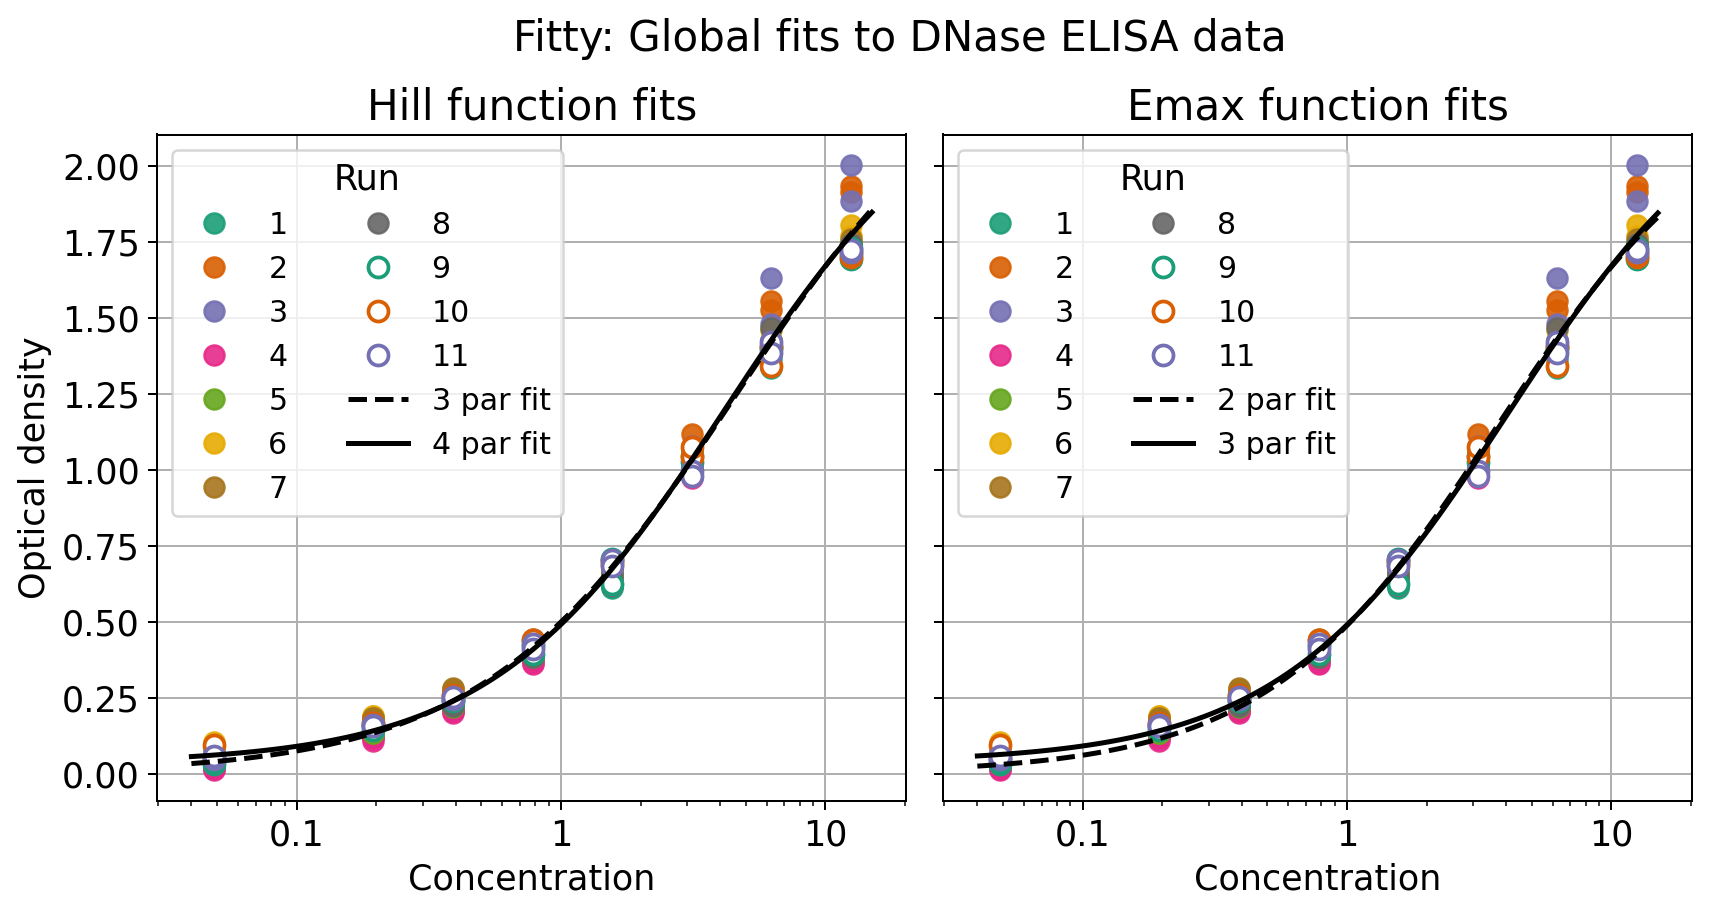

In [12]:
fig, splots = subplots(figsize = (11, 5), ncols = 2, sharex = "all", sharey = "all")

for ax in splots
    for (run, df) in pairs(groupby(data, :Run, sort = false))
        r = run.Run
        if r < 9
            ax.plot(df.conc, df.density, "o", ms = 8, alpha = 0.9, label = r)
        else
            ax.plot(df.conc, df.density, "o", ms = 8, mew = 1.5, mfc = "w", label = r)
        end
    end
    ax.set_xlabel("Concentration")
    ax.set_xscale("log")
    ax.set_xticks([0.1, 1, 10])
    ax.set_xticklabels(["0.1", "1", "10"])
    ax.grid()
end

ax = splots[0]
ax.plot(cvals, pred["Hill_3p"], "k--", lw = 2, label = "3 par fit")
ax.plot(cvals, pred["Hill_4p"], "k-", lw = 2, label = "4 par fit")
ax.set_title("Hill function fits")
ax.set_ylabel("Optical density")
ax.legend(title = "Run", fontsize = 12, ncols = 2)

ax = splots[1]
ax.plot(cvals, pred["Emax_2p"], "k--", lw = 2, label = "2 par fit")
ax.plot(cvals, pred["Emax_3p"], "k-", lw = 2, label = "3 par fit")
ax.set_title("Emax function fits")
ax.legend(title = "Run", fontsize = 12, ncols = 2)

subplots_adjust(top = 0.85, wspace = 0.05)
suptitle("Fitty: Global fits to DNase ELISA data");

## 5. Compare fits

`Fitty` provides several metrics to compare fits to a dataset with different models. These include:
1. Reduced $\chi^2$ statistic
2. AIC (Akaike Information Criterion), and
3. BIC (Bayes Information Criterion)

For the same data, a lower value of these metrics signifies a more parsimonous fit to a model taking into account different number of model parameters. The values of these metrics for each fit are printed out below

In [13]:
Redχ2vals = Dict(k => f.redChiSq for (k, f) in pairs(allfits))

Dict{String, Float64} with 4 entries:
  "Hill_3p" => 0.00219708
  "Hill_4p" => 0.0021221
  "Emax_3p" => 0.00211129
  "Emax_2p" => 0.00240945

In [14]:
AICvals = Dict(k => f.AIC for (k, f) in pairs(allfits))

Dict{String, Float64} with 4 entries:
  "Hill_3p" => -164.251
  "Hill_4p" => -169.383
  "Emax_3p" => -171.261
  "Emax_2p" => -148.997

In [15]:
BICvals = Dict(k => f.BIC for (k, f) in pairs(allfits))

Dict{String, Float64} with 4 entries:
  "Hill_3p" => -154.739
  "Hill_4p" => -156.701
  "Emax_3p" => -161.75
  "Emax_2p" => -142.656

These results show that the Emax model with non-zero baseline (3 parameter Emax model) produces the most parsimonious global fit to these data amongst the four models considered.  

In [16]:
SSRvals = Dict(k => f.SSR for (k, f) in pairs(allfits))

Dict{String, Float64} with 4 entries:
  "Hill_3p" => 0.380095
  "Hill_4p" => 0.365001
  "Emax_3p" => 0.365252
  "Emax_2p" => 0.419244

## 6. Individual fits

Fit each run separately with the three parameter Emax model

In [17]:
indifits = Dict()
lb, ub = [0, 0, 0, 1], [Inf, Inf, Inf, 1]
for (r, df) in pairs(groupby(data, :Run, sort = false))
    run = r.Run
    print("Run $run\n")
    indifits[run] = Fitty.nlsfit(residual, guess, data = df, lb = lb, ub = ub, bootstrap = true);
    println()
end

Run 1
Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.007, 2.271, 4.109, 1.0]
2000 bootstrap fits converged out of 2006 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate    StdErr     CI
   ┌──────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.00738942  0.0100394  [0.00053941, 0.0157123]
 2 │ ymax       [0.0, Inf]  2.27051     0.0362143  [2.23889, 2.29898]
 3 │ EC50       [0.0, Inf]  4.10853     0.183591   [3.94159, 4.28907]
 4 │ nHill      [1.0, 1.0]  1.0         0.0        [1.0, 1.0]

Sum of squared residuals = 5.208e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 2.002e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 2
Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.013, 2.613, 4.451, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0128023  0.00752548  [0.0064796, 0.0170592]
 2 │ ymax       [0.0, Inf]  2.61286    0.0295955   [2.58727, 2.63628]
 3 │ EC50       [0.0, Inf]  4.45086    0.136932    [4.31219, 4.56199]
 4 │ nHill      [1.0, 1.0]  1.0        0.0         [1.0, 1.0]

Sum of squared residuals = 3.016e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 1.523e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 3
Fit converged in 8 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.058, 2.678, 4.818, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌───────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0578865  0.019574   [0.048613, 0.0679038]
 2 │ ymax       [0.0, Inf]  2.67754    0.0840153  [2.58935, 2.77408]
 3 │ EC50       [0.0, Inf]  4.81753    0.404316   [4.48277, 5.18191]
 4 │ nHill      [1.0, 1.0]  1.0        0.0        [1.0, 1.0]

Sum of squared residuals = 2.100e-02
Degrees of freedom = 16 - 3 = 13
Residual standard error = 4.019e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 4
Fit did not converge in 2000 iterations starting with intial guess [0.0, 2.0, 1.0, 1.0]
Try a different starting guess, increase maxiter, or increase tolerances


Run 5
Fit converged in 6 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.011, 2.281, 3.842, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0112174  0.00655613  [0.0065732, 0.0159156]
 2 │ ymax       [0.0, Inf]  2.28081    0.022029    [2.26215, 2.29668]
 3 │ EC50       [0.0, Inf]  3.84161    0.107012    [3.72461, 3.93733]
 4 │ nHill      [1.0, 1.0]  1.0        0.0         [1.0, 1.0]

Sum of squared residuals = 2.164e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 1.290e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 6
Fit converged in 6 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.076, 2.362, 4.194, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌───────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0763726  0.0077014  [0.070837, 0.0816839]
 2 │ ymax       [0.0, Inf]  2.36218    0.0284001  [2.33401, 2.39212]
 3 │ EC50       [0.0, Inf]  4.19408    0.144299   [4.0685, 4.33102]
 4 │ nHill      [1.0, 1.0]  1.0        0.0        [1.0, 1.0]

Sum of squared residuals = 3.089e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 1.542e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 7
Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.078, 2.289, 4.103, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0783056  0.00633044  [0.0740591, 0.0834347]
 2 │ ymax       [0.0, Inf]  2.28942    0.0228035   [2.26664, 2.31029]
 3 │ EC50       [0.0, Inf]  4.10318    0.118232    [3.99157, 4.2144]
 4 │ nHill      [1.0, 1.0]  1.0        0.0         [1.0, 1.0]

Sum of squared residuals = 2.070e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 1.262e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 8
Fit converged in 6 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.029, 2.298, 4.042, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0290545  0.0113028  [0.0227933, 0.0349754]
 2 │ ymax       [0.0, Inf]  2.29817    0.0400733  [2.27477, 2.32899]
 3 │ EC50       [0.0, Inf]  4.0424     0.20068    [3.89694, 4.16828]
 4 │ nHill      [1.0, 1.0]  1.0        0.0        [1.0, 1.0]

Sum of squared residuals = 6.561e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 2.246e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 9
Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.023, 2.205, 3.651, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0230894  0.0109794  [0.0161011, 0.0310235]
 2 │ ymax       [0.0, Inf]  2.20543    0.0349924  [2.17376, 2.24182]
 3 │ EC50       [0.0, Inf]  3.65108    0.17152    [3.48744, 3.85165]
 4 │ nHill      [1.0, 1.0]  1.0        0.0        [1.0, 1.0]

Sum of squared residuals = 5.946e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 2.139e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 10
Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.049, 2.15, 3.485, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0489525  0.0110787  [0.0401683, 0.0566088]
 2 │ ymax       [0.0, Inf]  2.15025    0.0336629  [2.11941, 2.16889]
 3 │ EC50       [0.0, Inf]  3.48484    0.166683   [3.36169, 3.60821]
 4 │ nHill      [1.0, 1.0]  1.0        0.0        [1.0, 1.0]

Sum of squared residuals = 5.939e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 2.137e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates

Run 11
Fit converged in 7 steps from intial guess [0.0, 2.0, 1.0, 1.0]
to final estimate [0.044, 2.233, 3.877, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 4 rows:
     Parameter  Bounds      Estimate   StdErr     CI
   ┌────────────────────────────────────────────────────────────────────
 1 │ y0         [0.0, Inf]  0.0438128  0.0104877  [0.0354237, 0.0521409]
 2 │ ymax       [0.0, Inf]  2.23338    0.035581   [2.2074, 2.25898]
 3 │ EC50       [0.0, Inf]  3.87714    0.180142   [3.701, 4.05484]
 4 │ nHill      [1.0, 1.0]  1.0        0.0        [1.0, 1.0]

Sum of squared residuals = 5.557e-03
Degrees of freedom = 16 - 3 = 13
Residual standard error = 2.068e-02
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates



## 7. Plot individual fits

Generate model predictions for each fit, and overlay on data. 

In [18]:
pred = Dict()
for (r, f) in pairs(indifits)
    pred[r] = Hill(f.fit, cvals)
end

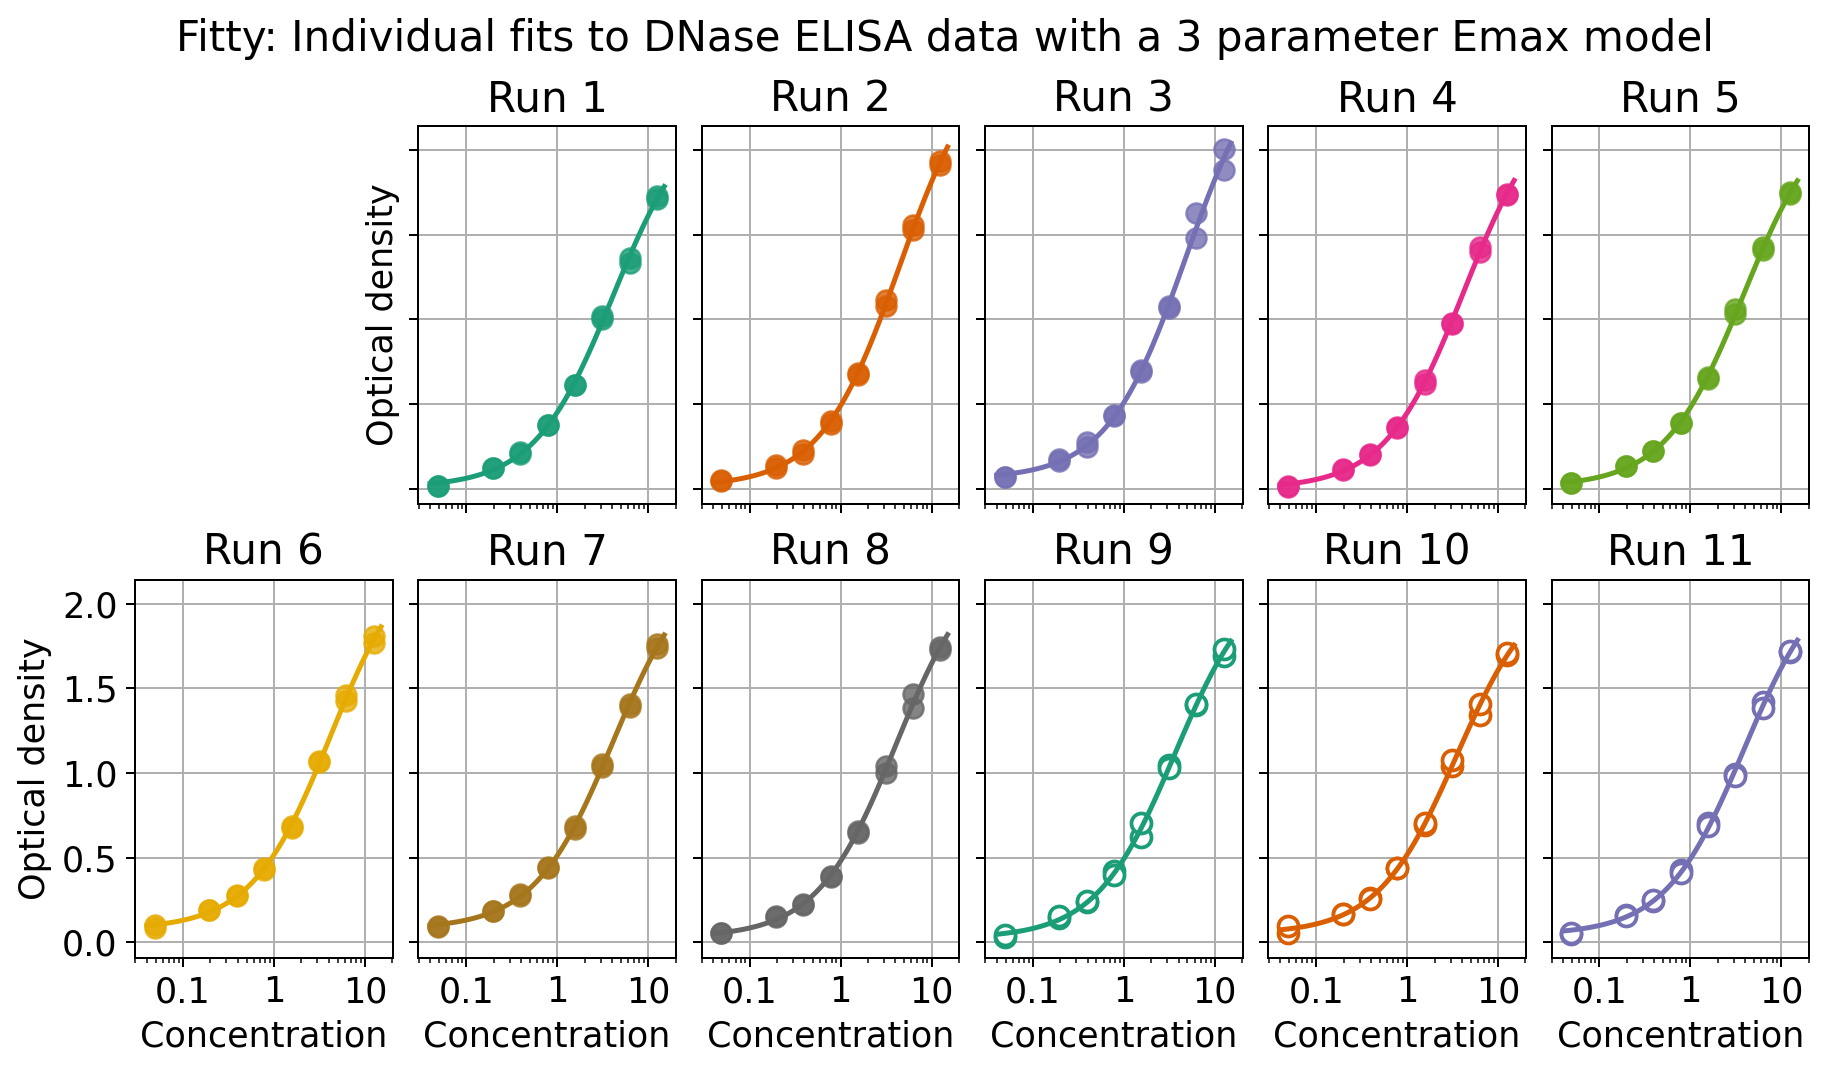

In [19]:
fig, splots = subplots(figsize = (12, 6), ncols = 6, nrows = 2, 
                       sharex = "all", sharey = "all")

for (r, df) in pairs(groupby(data, :Run, sort = false))
    run = r.Run
    ax = splots.ravel()[run]
    color = "C$(run-1)"
    if run < 9
        ax.plot(df.conc, df.density, "o", color = color, ms = 8, alpha = 0.8, label = r)
    else
        ax.plot(df.conc, df.density, "o", color = color, ms = 8, mew = 1.5, mfc = "w", label = r)
    end
    ax.plot(cvals, pred[run], color = color, lw = 2)
    ax.set_title("Run $run")
    ax.set_xscale("log")
    ax.grid()
end
ax = splots.ravel()[0]
ax.set_visible(false)
for ax in splots[1]
    ax.set_xlabel("Concentration")
    ax.set_xticks([0.1, 1, 10])
    ax.set_xticklabels(["0.1", "1", "10"])
end
for ax in (splots[0][1], splots[1][0])
    ax.set_ylabel("Optical density")
end

suptitle("Fitty: Individual fits to DNase ELISA data with a 3 parameter Emax model")
subplots_adjust(wspace = 0.1);

## 8. Compare global vs individual parameter estimates

Plot estimated values of the three model parameters for the global -vs- individual fits with the 3 parameter Emax model

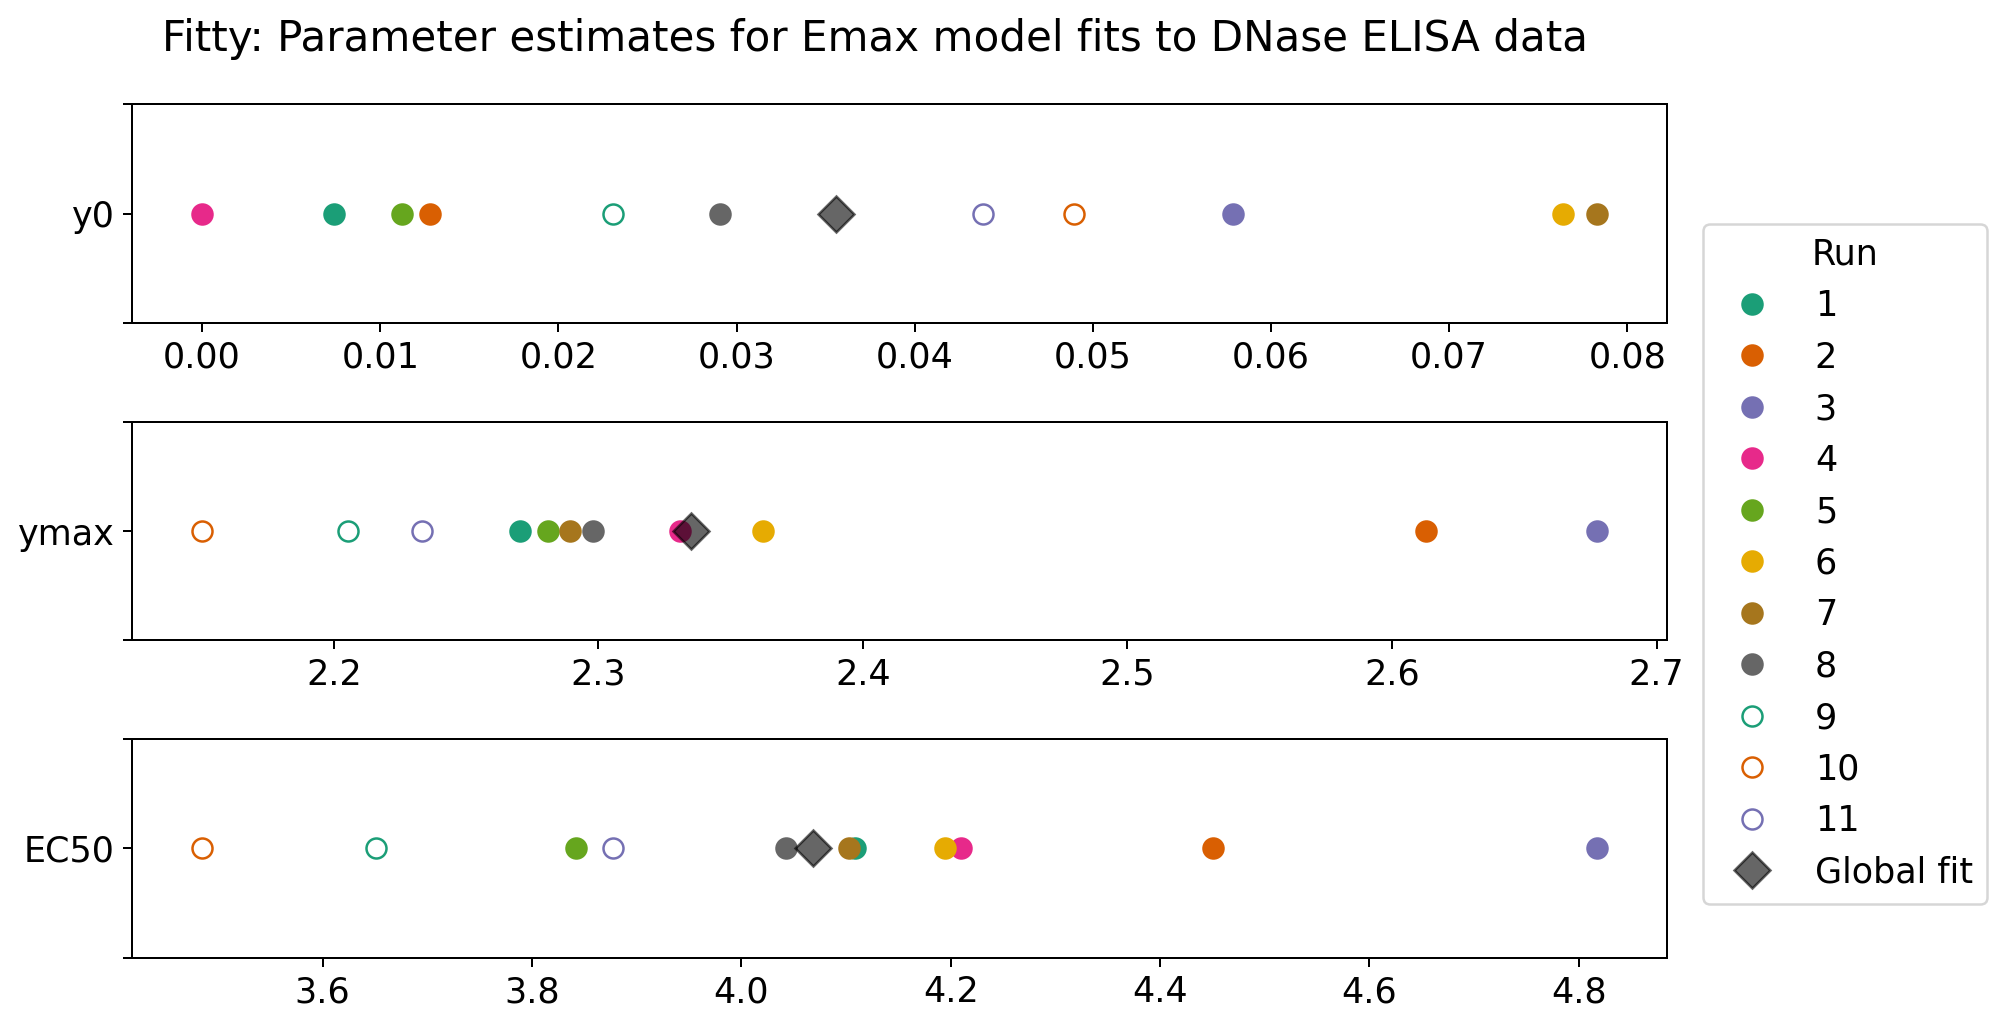

In [20]:
fig, splots = subplots(figsize = (11, 6), nrows = 3)

pars = ["y0", "ymax", "EC50"]
for (jj, ax) in enumerate(splots)
    for run in range(1, 11)
        f = indifits[run]
        color = "C$(run-1)"
        mfc = run < 9 ? color : "w"
        ax.plot(f.estimate[jj], 0, "o", ms = 8, color = color, mfc = mfc, label = run)
    end
    f = allfits["Emax_3p"]
    ax.plot(f.estimate[jj], 0, "kD", ms = 10, alpha = 0.6, label = "Global fit")
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(["", pars[jj], ""])
end

ax = splots[2]
ax.legend(title = "Run", loc = "right", bbox_to_anchor = [1.22, 1.8])
suptitle("Fitty: Parameter estimates for Emax model fits to DNase ELISA data")
subplots_adjust(top = 0.9, hspace = 0.45);

## 9. Summary

This notebooks shows how to fit a dose-response model curve to observed data using a Hill function or Emax model. DNase ELISA data reporting optical density -vs- concentration were fit to each model using either a zero or a non-zero baseline. The four fits were evaluated using several metrics for goodness-of-fits, that all support the Emax model with non-zero baseline (3-parameter Emax model) as the most parsimonious, based on the global fit. Individual fits were generated for each run within the dataset, and individual and global fit parameter estimates compared. 